In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch

# Rand reps, model init fixed

In [2]:
import sys
sys.path.append('../../')

import denn.utils as ut

In [3]:
# folder = lambda i: f"/Users/dylanrandle/Downloads/POS_run_gan_053020_seed{i}/val_mse.npy"
# gan_reps = []
# for i in range(5):
#     gan_reps.append(np.load(folder(i)))
# gan_reps = np.vstack(gan_reps)

In [3]:
# gan_reps = np.load('/Users/dylanrandle/Downloads/pos_reps_052620_gan.npy')

gan_reps = np.load('C:/Users/Blake Bullwinkel/Documents/Harvard/denn/experiments/reps/wav/wav_rand_reps_gan.npy')

l2_reps = np.load('C:/Users/Blake Bullwinkel/Documents/Harvard/denn/experiments/reps/wav/wav_rand_reps_L2.npy')

l1_reps = np.load('C:/Users/Blake Bullwinkel/Documents/Harvard/denn/experiments/reps/wav/wav_rand_reps_L1.npy')

huber_reps = np.load('C:/Users/Blake Bullwinkel/Documents/Harvard/denn/experiments/reps/wav/wav_rand_reps_huber.npy')

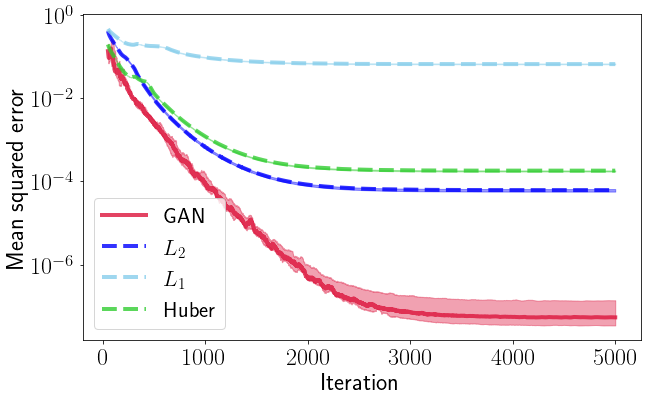

In [4]:
arrs_dict = {"GAN": gan_reps, 
             "$L_2$": l2_reps,
             "$L_1$": l1_reps, 
             "Huber": huber_reps,
#              "RK4": mse*np.ones_like(huber_reps)
            }
ut.plot_reps_results(arrs_dict, fname="wav_rand_reps.png",
                     window=50, figsize=(10,6), pctiles=(25,75), linewidth=4)

In [27]:
print(f"L1 Min: {np.min(l1_reps)}")
print(f"L2 Min: {np.min(l2_reps)}")
print(f"Huber Min: {np.min(huber_reps)}")
print(f"GAN Min: {np.min(gan_reps)}")

L1 Min: 0.06270967423915863
L2 Min: 4.466272366698831e-05
Huber Min: 0.00015940068988129497
GAN Min: 1.5185051438493247e-08


# Finite Diff

In [16]:
def solver(I, V, f, c, L, dt, C, T, user_action=None):
    """Solve u_tt=c^2*u_xx + f on (0,L)x(0,T]."""
    Nt = int(round(T/dt))
    t = np.linspace(0, Nt*dt, Nt+1)   # Mesh points in time
    dx = dt*c/float(C)
    Nx = int(round(L/dx))
    x = np.linspace(0, L, Nx+1)       # Mesh points in space
    C2 = C**2                      # Help variable in the scheme
    if f is None or f == 0 :
        f = lambda x, t: 0
    if V is None or V == 0:
        V = lambda x: 0

    u   = np.zeros(Nx+1)   # Solution array at new time level
    u_1 = np.zeros(Nx+1)   # Solution at 1 time level back
    u_2 = np.zeros(Nx+1)   # Solution at 2 time levels back

    import time;  t0 = time.time()  # for measuring CPU time

    # Load initial condition into u_1
    for i in range(0,Nx+1):
        u_1[i] = I(x[i])

    if user_action is not None:
        user_action(u_1, x, t, 0)

    # Special formula for first time step
    n = 0
    for i in range(1, Nx):
        u[i] = u_1[i] + dt*V(x[i]) + 0.5*C2*(u_1[i-1] - 2*u_1[i] + u_1[i+1]) + 0.5*dt**2*f(x[i], t[n])
    u[0] = 0;  u[Nx] = 0

    if user_action is not None:
        user_action(u, x, t, 1)

    # Switch variables before next step
    u_2[:] = u_1;  u_1[:] = u

    for n in range(1, Nt):
        # Update all inner points at time t[n+1]
        for i in range(1, Nx):
            u[i] = - u_2[i] + 2*u_1[i] + C2*(u_1[i-1] - 2*u_1[i] + u_1[i+1]) + dt**2*f(x[i], t[n])

        # Insert boundary conditions
        u[0] = 0;  u[Nx] = 0
        if user_action is not None:
            if user_action(u, x, t, n+1):
                break

        # Switch variables before next step
        u_2[:] = u_1;  u_1[:] = u

    cpu_time = t0 - time.time()
    return u, x, t, cpu_time

In [17]:
I = lambda x: np.sin(np.pi*x)
U, X, T, time = solver(I, 0, f=0, c=1, L=1, dt=1/32, C=1, T=1)

In [18]:
U.shape, X.shape, T.shape

((33,), (33,), (33,))

In [21]:
print(X, T)

[0.      0.03125 0.0625  0.09375 0.125   0.15625 0.1875  0.21875 0.25
 0.28125 0.3125  0.34375 0.375   0.40625 0.4375  0.46875 0.5     0.53125
 0.5625  0.59375 0.625   0.65625 0.6875  0.71875 0.75    0.78125 0.8125
 0.84375 0.875   0.90625 0.9375  0.96875 1.     ] [0.      0.03125 0.0625  0.09375 0.125   0.15625 0.1875  0.21875 0.25
 0.28125 0.3125  0.34375 0.375   0.40625 0.4375  0.46875 0.5     0.53125
 0.5625  0.59375 0.625   0.65625 0.6875  0.71875 0.75    0.78125 0.8125
 0.84375 0.875   0.90625 0.9375  0.96875 1.     ]


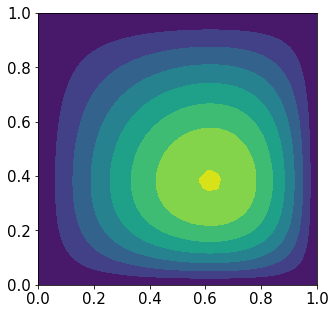

In [31]:
plt.figure(figsize=(5,5))
plt.contourf(X, Y, U)

In [27]:
def anal_sol(x, y):
    return x*(1-x)*y*(1-y)*np.exp(x-y)

In [28]:
U_an = anal_sol(X, Y)

In [29]:
U_an.shape

(32, 32)

In [30]:
np.mean((U - U_an)**2)

3.248673419947458e-10